# Housing Price Analysis in Ireland

### Context
All residential properties sold in Ireland from 2010 to May 28th 2021 (28/05/21)

### Content
- SALE_DATE	=> Date of sale (dd/MM/yyyy) | datatime64[ns]
- ADDRESS => Address | string
- POSTAL_CODE => Postal Code | string
- COUNTY => County | string
- SALE_PRICE => Price (€) | float32
- IF_MARKET_PRICE => Not Full Market Price | int8
- IF_VAT_EXCLUDED => VAT Exclusive | int8
- PROPERTY_DESC => Description of Property | string
- PROPERTY_SIZE_DESC => Property Size Description | string

### Library Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


### Dataset Reading

In [2]:
df = pd.read_csv('Property_Price_Register_Ireland-28-05-2021.csv')

# Preprocessing

### Observing and describing data

Gathering information about the dataset to get initial impressions and identify any necessary corrections for further analysis.

In [3]:
df.head()

,SALE_DATE,ADDRESS,POSTAL_CODE,COUNTY,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,PROPERTY_DESC,PROPERTY_SIZE_DESC
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,343000.0,0,0,Second-Hand Dwelling house /Apartment,NaN
1,2010-01-03,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,0,1,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,2010-01-04,"1 Meadow Avenue, Dundrum, Dublin 14",NaN,Dublin,438500.0,0,0,Second-Hand Dwelling house /Apartment,NaN
3,2010-01-04,"1 The Haven, Mornington",NaN,Meath,400000.0,0,0,Second-Hand Dwelling house /Apartment,NaN
4,2010-01-04,"11 Melville Heights, Kilkenny",NaN,Kilkenny,160000.0,0,0,Second-Hand Dwelling house /Apartment,NaN


In [4]:
df.shape

(476745, 9)

In [5]:
df.describe()

,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED
count,4.767450e+05,476745.000000,476745.000000
mean,2.590403e+05,0.048984,0.159618
std,8.526791e+05,0.215835,0.366252
min,5.030530e+03,0.000000,0.000000
25%,1.150000e+05,0.000000,0.000000
50%,1.950000e+05,0.000000,0.000000
75%,3.000000e+05,0.000000,0.000000
max,1.701428e+08,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476745 entries, 0 to 476744
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SALE_DATE           476745 non-null  object 
 1   ADDRESS             476745 non-null  object 
 2   POSTAL_CODE         89764 non-null   object 
 3   COUNTY              476745 non-null  object 
 4   SALE_PRICE          476745 non-null  float64
 5   IF_MARKET_PRICE     476745 non-null  int64  
 6   IF_VAT_EXCLUDED     476745 non-null  int64  
 7   PROPERTY_DESC       476745 non-null  object 
 8   PROPERTY_SIZE_DESC  52792 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 32.7+ MB


In [7]:
df.isnull().sum()

SALE_DATE                  0
ADDRESS                    0
POSTAL_CODE           386981
COUNTY                     0
SALE_PRICE                 0
IF_MARKET_PRICE            0
IF_VAT_EXCLUDED            0
PROPERTY_DESC              0
PROPERTY_SIZE_DESC    423953
dtype: int64

### Function imprimir_valores_unicos()

A function that prints the unique values of each variable.

In [8]:
def imprimir_valores_unicos(data_f):
    for coluna in data_f.columns:
        valores_unicos = data_f[coluna].unique()
        print(f"  {coluna} = {valores_unicos}")

imprimir_valores_unicos(df)

  SALE_DATE = ['2010-01-01' '2010-01-03' '2010-01-04' ... '2021-05-26' '2021-05-27'
 '2021-05-28']
  ADDRESS = ['5 Braemor Drive, Churchtown, Co.Dublin'
 '134 Ashewood Walk, Summerhill Lane, Portlaoise'
 '1 Meadow Avenue, Dundrum, Dublin 14' ... 'MULTYFARNHAM, WESTMEATH'
 'NO 2 RIVERLODGE, SHRONE, GLENGARIFF' 'RABANE, KILL, COOTEHILL']
  POSTAL_CODE = [nan 'Dublin 14' 'Dublin 2' 'Dublin 13' 'Dublin 12' 'Dublin 4' 'Dublin 11'
 'Dublin 9' 'Dublin 24' 'Dublin 15' 'Dublin 22' 'Dublin 5' 'Dublin 18'
 'Dublin 6' 'Dublin 6w' 'Dublin 7' 'Dublin 16' 'Dublin 8' 'Dublin 3'
 'Dublin 1' 'Dublin 17' 'N� Bhaineann' 'Dublin 20' 'Dublin 10'
 'Baile �tha Cliath 14' 'Baile ?tha Cliath 17' 'Baile �tha Cliath 5'
 'Baile �tha Cliath 3' 'Baile �tha Cliath 15' 'Baile �tha Cliath 4'
 'Baile �tha Cliath 9' 'Baile �tha Cliath 18']
  COUNTY = ['Dublin' 'Laois' 'Meath' 'Kilkenny' 'Limerick' 'Carlow' 'Cork' 'Clare'
 'Sligo' 'Cavan' 'Tipperary' 'Wicklow' 'Roscommon' 'Wexford' 'Mayo'
 'Donegal' 'Longford' 'Galway' 'O

### Exclusion of Variables

The variables POSTAL_CODE and PROPERTY_SIZE_DESC have 386,981 and 423,953 null values respectively and should be excluded due to missing data.

In [9]:
df = df.drop(columns=['POSTAL_CODE','PROPERTY_SIZE_DESC'])
df

,SALE_DATE,ADDRESS,COUNTY,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,PROPERTY_DESC
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,343000.0,0,0,Second-Hand Dwelling house /Apartment
1,2010-01-03,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,185000.0,0,1,New Dwelling house /Apartment
2,2010-01-04,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,438500.0,0,0,Second-Hand Dwelling house /Apartment
3,2010-01-04,"1 The Haven, Mornington",Meath,400000.0,0,0,Second-Hand Dwelling house /Apartment
4,2010-01-04,"11 Melville Heights, Kilkenny",Kilkenny,160000.0,0,0,Second-Hand Dwelling house /Apartment
...,...,...,...,...,...,...,...
476740,2021-05-28,"GRANGE STORES, GRANGE, MULLINGAR",Westmeath,150000.0,0,0,Second-Hand Dwelling house /Apartment
476741,2021-05-28,"MAIN STREET, LOWER BORRIS, BORRIS",Carlow,170000.0,1,0,Second-Hand Dwelling house /Apartment
476742,2021-05-28,"MULTYFARNHAM, WESTMEATH",Westmeath,175000.0,0,0,Second-Hand Dwelling house /Apartment
476743,2021-05-28,"NO 2 RIVERLODGE, SHRONE, GLENGARIFF",Cork,240000.0,0,0,Second-Hand Dwelling house /Apartment


### Inconsistent Data

In PROPERTY_DESC, there are some data containing unknown characters. They are considered null and their records are deleted afterwards.

In [10]:
df["PROPERTY_DESC"] = df["PROPERTY_DESC"].replace(to_replace="Teach/�ras�n C�naithe Ath�imhe", value=np.nan)
df["PROPERTY_DESC"] = df["PROPERTY_DESC"].replace(to_replace="Teach/�ras�n C�naithe Nua", value=np.nan)
df["PROPERTY_DESC"] = df["PROPERTY_DESC"].replace(to_replace="Teach/?ras?n C?naithe Nua", value=np.nan)

df = df.dropna(axis = 0, how ='any') 

### Duplicate Data

Duplicate data (770 records) are found and deleted.

In [11]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: " , duplicate_rows_df.shape)

number of duplicate rows:  (770, 7)


In [12]:
df = df.drop_duplicates()

### Results

With data cleaning, the columns POSTAL_CODE and PROPERTY_SIZE_DESC were deleted due to their large majority of null data, and 804 records were deleted due to duplicity or incorrect data.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 475941 entries, 0 to 476744
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SALE_DATE        475941 non-null  object 
 1   ADDRESS          475941 non-null  object 
 2   COUNTY           475941 non-null  object 
 3   SALE_PRICE       475941 non-null  float64
 4   IF_MARKET_PRICE  475941 non-null  int64  
 5   IF_VAT_EXCLUDED  475941 non-null  int64  
 6   PROPERTY_DESC    475941 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 29.0+ MB


### Separation of Month and Year

The variable SALE_DATE is split into month and year to facilitate temporal analysis.

In [14]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

df['SALE_MONTH'] = df['SALE_DATE'].dt.month
df['SALE_YEAR'] = df['SALE_DATE'].dt.year

In [15]:
df

,SALE_DATE,ADDRESS,COUNTY,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,PROPERTY_DESC,SALE_MONTH,SALE_YEAR
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,343000.0,0,0,Second-Hand Dwelling house /Apartment,1,2010
1,2010-01-03,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,185000.0,0,1,New Dwelling house /Apartment,1,2010
2,2010-01-04,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,438500.0,0,0,Second-Hand Dwelling house /Apartment,1,2010
3,2010-01-04,"1 The Haven, Mornington",Meath,400000.0,0,0,Second-Hand Dwelling house /Apartment,1,2010
4,2010-01-04,"11 Melville Heights, Kilkenny",Kilkenny,160000.0,0,0,Second-Hand Dwelling house /Apartment,1,2010
...,...,...,...,...,...,...,...,...,...
476740,2021-05-28,"GRANGE STORES, GRANGE, MULLINGAR",Westmeath,150000.0,0,0,Second-Hand Dwelling house /Apartment,5,2021
476741,2021-05-28,"MAIN STREET, LOWER BORRIS, BORRIS",Carlow,170000.0,1,0,Second-Hand Dwelling house /Apartment,5,2021
476742,2021-05-28,"MULTYFARNHAM, WESTMEATH",Westmeath,175000.0,0,0,Second-Hand Dwelling house /Apartment,5,2021
476743,2021-05-28,"NO 2 RIVERLODGE, SHRONE, GLENGARIFF",Cork,240000.0,0,0,Second-Hand Dwelling house /Apartment,5,2021


### Conversion of Categorized Values to Numeric
Converting categorical variables into numerical values allows for a wider range of algorithms to be used in the Machine Learning model, and in some models, it is required that all input variables be numeric. Additionally, it helps to standardize the data and make it easier to interpret and analyze.

##### One-Hot Encoding (Dummy Variabls)

In the COUNTY variable, there are several categories, and the technique of 'dummy variables' is used to ensure that the numerical values assigned to the categories are not interpreted as ordinal values (i.e., values that have a specific order).

In [16]:
one_hot_encoded = pd.get_dummies(df['COUNTY'])

# Concatenate the one-hot variables to the original DataFrame
df = pd.concat([df, one_hot_encoded], axis=1)

##### Value Transformation
The variable PROPERTY_DESC has only two values ('Second-Hand Dwelling house /Apartment' and 'New Dwelling house /Apartment'), and we can replace them with 0 and 1, respectively.y.

In [17]:
# Map values to booleans
mapeamento = {'Second-Hand Dwelling house /Apartment': 0, 'New Dwelling house /Apartment': 1}
df['PROPERTY_DESC'] = df['PROPERTY_DESC'].map(mapeamento)

### Final Result

In [18]:
df

,SALE_DATE,ADDRESS,COUNTY,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,PROPERTY_DESC,SALE_MONTH,SALE_YEAR,Carlow,...,Meath,Monaghan,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,343000.0,0,0,0,1,2010,False,...,False,False,False,False,False,False,False,False,False,False
1,2010-01-03,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,185000.0,0,1,1,1,2010,False,...,False,False,False,False,False,False,False,False,False,False
2,2010-01-04,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,438500.0,0,0,0,1,2010,False,...,False,False,False,False,False,False,False,False,False,False
3,2010-01-04,"1 The Haven, Mornington",Meath,400000.0,0,0,0,1,2010,False,...,True,False,False,False,False,False,False,False,False,False
4,2010-01-04,"11 Melville Heights, Kilkenny",Kilkenny,160000.0,0,0,0,1,2010,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476740,2021-05-28,"GRANGE STORES, GRANGE, MULLINGAR",Westmeath,150000.0,0,0,0,5,2021,False,...,False,False,False,False,False,False,False,True,False,False
476741,2021-05-28,"MAIN STREET, LOWER BORRIS, BORRIS",Carlow,170000.0,1,0,0,5,2021,True,...,False,False,False,False,False,False,False,False,False,False
476742,2021-05-28,"MULTYFARNHAM, WESTMEATH",Westmeath,175000.0,0,0,0,5,2021,False,...,False,False,False,False,False,False,False,True,False,False
476743,2021-05-28,"NO 2 RIVERLODGE, SHRONE, GLENGARIFF",Cork,240000.0,0,0,0,5,2021,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
ProfileReport(df)

# Model performance evaluation
### Split the dataset
Continuous variables were removed when adding the independent variables to X. The variable SALE_PRICE is the independent variable.

In [19]:
X = df.drop(columns=['SALE_DATE','ADDRESS','COUNTY','SALE_PRICE'])
y = df['SALE_PRICE']

### k-fold cross-validation
Application of K-fold cross-validation in conjunction with cross_val_score to evaluate the model performance, in order to obtain an estimate of the model's performance and avoid bias that may arise from a single train/test split.

In [20]:
# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate the linear regression model
lr = LinearRegression()

#Perform cross-validation and get R2 scores
cross_val_scores = cross_val_score(lr, X, y, cv=kf, scoring='r2')

In [21]:
# Print the R2 scores for each fold
for i, score in enumerate(cross_val_scores, start=1):
    print(f"Fold {i}: R2 Score = {score}")

# Print the average R2 score across all folds
average_r2 = np.mean(cross_val_scores)
print(f"\nAverage R2 Score: {average_r2}")

Fold 1: R2 Score = 0.021698710612204963
Fold 2: R2 Score = 0.020074306891520455
Fold 3: R2 Score = 0.020110713003313685
Fold 4: R2 Score = 0.015086185506455463
Fold 5: R2 Score = 0.03106748038208107

Average R2 Score: 0.021607479279115126


### Hyperparameter Tuning
Evaluate the model performance for each combination of hyperparameters and find the value that produces the best average performance

In [22]:
# Defining the hyperparameters to tune
parameters = {'fit_intercept': [True, False]}

In [23]:
# Instantiate the GridSearchCV
grid_search = GridSearchCV(lr, parameters, cv=kf, scoring='r2')

# Fit the model to the data
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]}, scoring='r2')

In [24]:
# Print the best hyperparameters found
print("Melhores hiperparâmetros:", grid_search.best_params_)

# Print the best mean score obtained during cross-validation
print("Melhor escore médio:", grid_search.best_score_)

Melhores hiperparâmetros: {'fit_intercept': False}
Melhor escore médio: 0.021608914686290514


# Train & Text
Testando atraves de um modelo de Regressâo linear

In [25]:
# Split the dataset between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
# Display the rows and columns (dimenions) of an unsplitted dataset
print('Total number of rows and columns for the complete dataset: ', X.shape, y.shape)

# Display the rows and columns (dimenions) of the splitted dataset
print('Number of rows and columns after splitting dataset: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape )

Total number of rows and columns for the complete dataset:  (475941, 31) (475941,)
Number of rows and columns after splitting dataset:  (356955, 31) (118986, 31) (356955,) (118986,)


In [27]:
# Train the model
lr.fit(X_train, y_train)

LinearRegression()

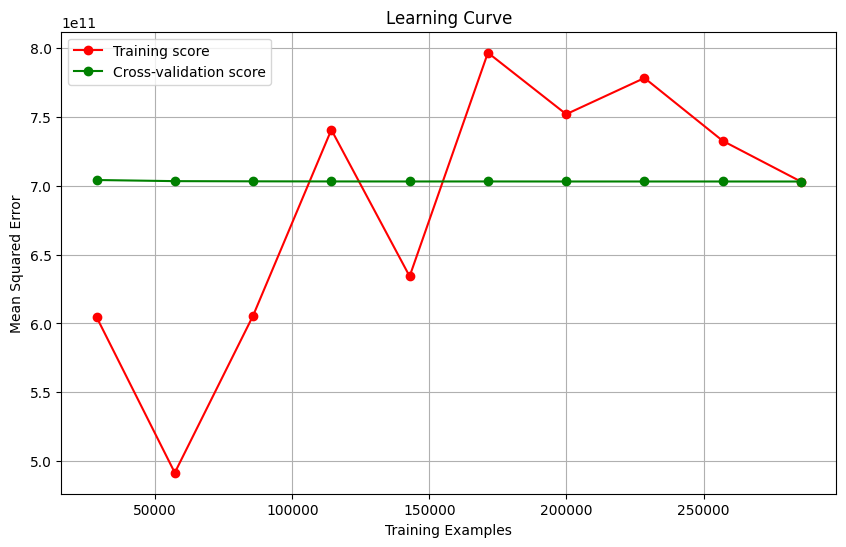

In [28]:
# Function to plot learning curves  
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot learning curves  
plot_learning_curve(lr, X_train, y_train)

In [29]:
# Final Model Tuning
final_r2 = lr.score(X_test, y_test)
print(f"Final R2 Score: {final_r2}")

Final R2 Score: 0.020185897934124286


In [30]:
# Method to calculate the score
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv = 10,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

# Calculate the mean values and Standard deviation
get_cv_scores(lr)

CV Mean:  0.027273068874712036
STD:  0.012540281502774801




### Training Data at 20%
 - CV Mean:  0.02773487733280532
 - STD:  0.014378210575627043

### Training Data at 25%
 - CV Mean:  0.027273068874712036
 - STD:  0.012540281502774801

### Training Data at 30%
 - CV Mean:  0.02933943683630378
 - STD:  0.01828222874297337


In [31]:
print('Training set score: {:.2f}'.format(lr.score(X_train, y_train)))
print('Test set score: {:.2f}'.format(lr.score(X_test, y_test)))

Training set score: 0.02
Test set score: 0.02


In [32]:
# Calculate the intercept and coefficient
print(lr.intercept_)
print(lr.coef_)

-9306173353892060.0
[-6.90781601e+04 -5.72013645e+04  8.55938672e+04  1.72851796e+03
  1.33942568e+04  9.30617333e+15  9.30617333e+15  9.30617333e+15
  9.30617333e+15  9.30617333e+15  9.30617333e+15  9.30617333e+15
  9.30617333e+15  9.30617333e+15  9.30617333e+15  9.30617333e+15
  9.30617333e+15  9.30617333e+15  9.30617333e+15  9.30617333e+15
  9.30617333e+15  9.30617333e+15  9.30617333e+15  9.30617333e+15
  9.30617333e+15  9.30617333e+15  9.30617333e+15  9.30617333e+15
  9.30617333e+15  9.30617333e+15  9.30617333e+15]


In [33]:
# Calculate the predicted values
y_pred = lr.predict(X_test)
# y_pred
print(y_pred)

[454432. 329992. 222972. ...  95384. 452580.  88900.]


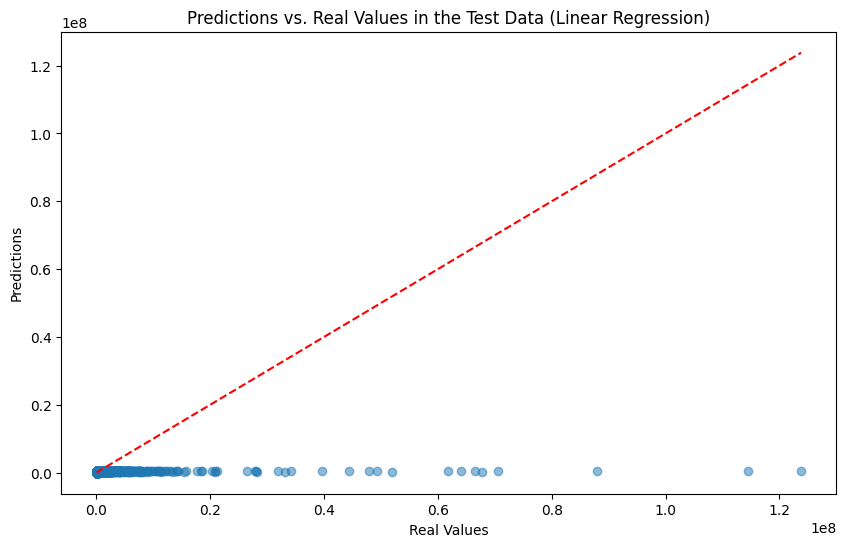

In [34]:
# Plot predictions versus actual values on the test data for a Linear Regression model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. Real Values in the Test Data (Linear Regression)')
plt.show()


In [35]:
# Calculate the error values
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 135066.27217907988
Mean Squared Error: 740614902523.5021
Root Mean Squared Error: 860589.8573208391


### Training Data at 20%
 - Mean Absolute Error: 134477.1913654939
 - Mean Squared Error: 666905114322.789
 - Root Mean Squared Error: 816642.586645338

### Training Data at 25%
 - Mean Absolute Error: 135066.27217907988
 - Mean Squared Error: 740614902523.5021
 - Root Mean Squared Error: 860589.8573208391

### Training Data at 30%
 - Mean Absolute Error: 134568.7716074568
 - Mean Squared Error: 738080555924.3677
 - Root Mean Squared Error: 859116.1480989446

# Randon Forest Regression
Randon Forest foi escolhido como modelo para comparar os resultados com o modelo de Regressão Linear. KFold e GridSearchCV também estâo sendo utilizados.

In [36]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Define the hyperparameters to be tuned
param_grid = {
    'n_estimators': [100],
    #'n_estimators': [100, 200, 300],
    'max_depth': [10, 20],
    #'max_depth': [10, 20, 30],
    'min_samples_split': [5]
    #'min_samples_split': [2, 5, 10]
}


In [38]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor()

# Initialize the KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')


In [39]:
# Fit the model to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20], 'min_samples_split': [5],
                         'n_estimators': [100]},
             scoring='neg_mean_squared_error')

In [ ]:
# Function to plot learning curves
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot learning curves
plot_learning_curve(rf_model, X_train, y_train)

In [ ]:
# Best hyperparameters found
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

In [ ]:
# Evaluate the model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

In [ ]:
r2 = r2_score(y_test, y_pred)
print("Determination Coefficient (R2):", r2)

In [ ]:
# Extract the feature importance from the best model
feature_importance = best_model.feature_importances_

# Get the name of the features
feature_names = list(df.columns)

# Sort the feature indices by importance
sorted_indices = feature_importance.argsort()

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), feature_importance[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of the Random Forest Model')
plt.show()

In [ ]:
# Plot the predictions versus actual values on the test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. Real Values in the Test Data (Linear Regression)')
plt.show()